In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
#load in the hospital sites data to be used to score potential viable locations
hospitals = pd.read_csv('/Users/muhammad-faaiz.shanawas/Documents/Live Projects/MCLP/data/cambridge_uni_hospital_sites.csv')
hospitals

,Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,Open Date,Close Date,Organisation Sub-Type Code,Parent Org Code
0,A6B3B,CUH AT MEADOWS COMMUNITY CENTRE,Y61,QUE,1 ST. CATHARINES ROAD,NaN,NaN,CAMBRIDGE,NaN,CB4 3XJ,20211001,NaN,NaN,RGT
1,A9J5N,CUH AT ROSMINI CENTRE,Y61,QUE,69A QUEENS ROAD,NaN,NaN,WISBECH,NaN,PE13 2PH,20220401,NaN,NaN,RGT
2,B1C9Z,CUH AT SPECSAVERS ROYSTON,Y61,QUE,27A-27B HIGH STREET,NaN,NaN,ROYSTON,NaN,SG8 9AA,20220401,NaN,NaN,RGT
3,B5D1I,CUH AT DODDINGTON HOSPITAL,Y61,QUE,BENWICK ROAD,DODDINGTON,NaN,MARCH,NaN,PE15 0UG,20210401,NaN,NaN,RGT
4,C5Z7J,CAMBRIDGE BIOMEDICAL RESEARCH CENTRE - VALNEVA...,Y61,QUE,HILLS ROAD,NaN,NaN,CAMBRIDGE,NaN,CB2 0QQ,20210401,NaN,NaN,RGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,RGT98,NUFFIELD HEALTH CAMBRIDGE HOSPITAL,Y61,QUE,4 TRUMPINGTON ROAD,NaN,NaN,CAMBRIDGE,CAMBRIDGESHIRE,CB2 8AF,20121001,NaN,NaN,RGT
174,RGT99,ST MARY'S SURGERY,Y61,QUE,37 ST. MARYS STREET,NaN,NaN,ELY,CAMBRIDGESHIRE,CB7 4HF,20121001,NaN,NaN,RGT
175,T4O3M,CUH AT COLCHESTER STARS,Y61,QUE,5A QUEEN STREET,NaN,NaN,COLCHESTER,NaN,CO1 2PG,20210401,NaN,NaN,RGT
176,T8C3T,CUH AT ROYAL PAPWORTH HOSPITAL,Y61,QUE,PAPWORTH ROAD,CAMBRIDGE BIOMEDICAL CAMPUS,NaN,CAMBRIDGE,NaN,CB2 0AY,20201001,NaN,NaN,RGT


In [4]:
#load in pyrosm package to be able to calculate multiple shortest routes
from pyrosm import OSM, get_data
import osmnx as ox

# Get all walkable roads and the nodes 
osmCambridge = OSM(get_data("Cambridge"))
#store the nodes and edges to create our 100 node sample base for scoring
nodes, edges = osmCambridge.get_network(nodes=True)

In [5]:
#generate the network x graph from the nodes and edges retrieved through Pyrosm
G = osmCambridge.to_graph(nodes, edges, graph_type="networkx")

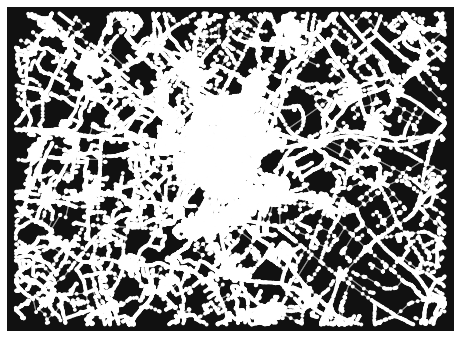

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
#plot the networkx graph
ox.plot_graph(G)

In [32]:
#get the target addresses from the hospitals dataframe
target_index1 = 176
target_index2 = 173

target_address1 = hospitals['Address Line 1'][target_index1] + ', Cambridge'
target_address2 = hospitals['Address Line 1'][target_index2] + ', Cambridge'

#convert the addresses to lat long coordinates and get the nearest node on the graph
target_coords1 = ox.geocode(target_address1)
target_node1 = ox.get_nearest_node(G, target_coords1)

target_coords2 = ox.geocode(target_address2)
target_node2 = ox.get_nearest_node(G, target_coords2)

list_of_target_nodes = [target_node1, target_node2]

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [33]:
#generate the random sample of 100 samples by first removing the target node location from the dataframe
nodes_df = nodes.copy()
nodes_df = nodes_df[~nodes_df['id'].isin(list_of_target_nodes)] #get the dataframe of nodes that do not have any target nodes in them
nodes_sample = nodes_df[['id', 'lon', 'lat']].sample(n = 100, random_state = 1234)
nodes_sample

,id,lon,lat
109510,8646394360,0.047724,52.214240
115390,9751860916,0.002643,52.204634
71291,1805021840,0.180775,52.194739
100169,7130530214,0.131952,52.192429
98324,1642015995,0.141220,52.175463
...,...,...,...
46735,1200557717,0.051677,52.124201
69764,260370856,0.079896,52.151723
79710,474690531,0.019639,52.238779
19339,25905135,0.253457,52.219996


In [11]:
#creating a function to calculate a score from a list of lengths calculated from the target node to each of the 100 sample nodes
def create_score(list_of_lengths):
    score = 1000
    for l in list_of_lengths:
        deduction = (((l/1000)/4.5)*60) * 5 #get the length in km divide by speed 4.5 km/h then divide by 60 to get time in minutes
        score = score - deduction #decrement the score by the derivation of time taken to each of the 100 nodes
        return score

In [12]:
#define a function to calculate multiple shortest route lengths from the target node to each of the 100 sample nodes
def create_list_of_lengths(nodes_sample, target_node):
    list_of_lengths = []
    for idx in range(nodes_sample.shape[0]):
        coords = (nodes_sample['lat'].iloc[idx], nodes_sample['lon'].iloc[idx])
        node = ox.get_nearest_node(G, coords) #get the nearest node in the graph from the nodes_sample dataframe
        length = nx.shortest_path_length(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_lengths.append(length) #append the length to the list
        idx += 1
    
    return list_of_lengths
    

In [35]:
#run the function defined above to generate a list of lengths between the target nodes and sample nodes
#then generate the score for each and store them in a dictionary
target_scores = {}
target_scores['Site 1'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[0]))
target_scores['Site 2'] = create_score(create_list_of_lengths(nodes_sample, list_of_target_nodes[1]))
target_scores

/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

{'Site 1': 348.66033333333405, 'Site 2': 508.13126666666653}

In [58]:
#print the scores for each proposed target site
print('The score for Site 1: {} is {}'.format(hospitals['Name'].iloc[target_index1], target_scores['Site 1']))
print('The score for Site 2: {} is {}'.format(hospitals['Name'].iloc[target_index2], target_scores['Site 2']))

The score for Site 1: CUH AT ROYAL PAPWORTH HOSPITAL is 348.66033333333405
The score for Site 2: NUFFIELD HEALTH CAMBRIDGE HOSPITAL is 508.13126666666653


In [37]:
#initiate dictionary to store routes for all 100 nodes for each proposed site
target_to_nodes_routes = {}
target_node_names = ['Site1', 'Site2']

In [39]:
#generate multiple shortest routes for each site and store in dictionary for plotting
for site, target_node in zip(target_node_names, list_of_target_nodes):
    list_of_routes = []
    for idx in range(nodes_sample.shape[0]):
        coords = (nodes_sample['lat'].iloc[idx], nodes_sample['lon'].iloc[idx])
        node = ox.get_nearest_node(G, coords) #get the nearest node in the graph from the nodes_sample dataframe
        route = nx.shortest_path(G, source=node, target=target_node, weight='length') #calculate route from target node to sample node
        list_of_routes.append(route) #append the length to the list
        idx += 1
    target_to_nodes_routes[site] = list_of_routes
    


/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

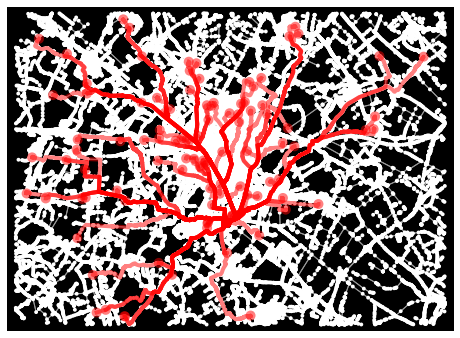

In [46]:
#plot the routes from Site 1 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site1'], route_linewidth=6, bgcolor='k')

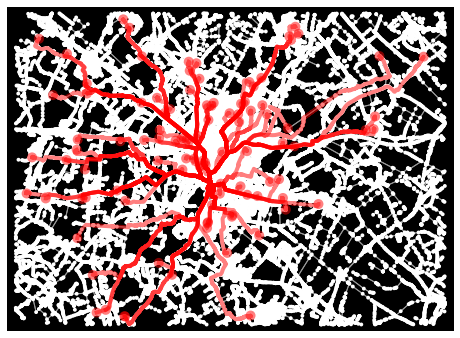

In [52]:
#plot the routes from Site 2 to all 100 sample nodes
fig, ax = ox.plot_graph_routes(G, target_to_nodes_routes['Site2'], route_linewidth=6, bgcolor='k')

## Next Steps
- Selecting n (arbitrarily set at 100) as a percentage of area population (taken from GP practice population data by LSOA)
<br> <br />
- Weighting each of the sample nodes according to different metrics that we can separate by LSOA (deprivation, internet usage/access e.tc) - integrate work from Max and Nick to get metrics/data
<br> <br />
- How does the location of existing hospitals/sites effect the scoring (weight the nodes greater if closer to another location?, KNN based approach to scoring?) 